In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score


try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    !pip install -q sentence-transformers
    from sentence_transformers import SentenceTransformer


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os

EXCEL_PATH = "/content/drive/MyDrive/Harvard HW#5/derm.xlsx"

print("Using path:", EXCEL_PATH)
print("File exists:", os.path.exists(EXCEL_PATH))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using path: /content/drive/MyDrive/Harvard HW#5/derm.xlsx
File exists: True


In [3]:
# Load and expload inclusion criteria

def load_and_expand_criteria(
    path: str,
    id_col: str = "nctid",
    crit_col: str = "inclusion"
) -> pd.DataFrame:

    df_raw = pd.read_excel(path)

    print("Columns:", df_raw.columns.tolist())

    df = df_raw[[id_col, crit_col]].copy()

    df[crit_col] = df[crit_col].astype(str)

    rows = []
    splitter = re.compile(r"(\n|\r|\r\n|\*)")

    for _, row in df.iterrows():
        nctid = row[id_col]
        text = row[crit_col]

        raw_parts = [p.strip() for p in splitter.split(text)
                     if p.strip() and p.strip() != "*"]

        cleaned_parts = []
        for p in raw_parts:
            p = re.sub(r"^[\-\*\u2022]?\s*(\d+[\.\)]\s*)?", "", p).strip()
            if len(p) > 0:
                cleaned_parts.append(p)

        for crit in cleaned_parts:
            rows.append({"nctid": nctid, "criterion": crit})

    expanded = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
    print("Expanded to", len(expanded), "rows")
    return expanded


In [4]:
criteria_df = load_and_expand_criteria(EXCEL_PATH, crit_col="inclusion")
criteria_df.head()

Columns: ['nctid', 'inclusion']
Expanded to 26369 rows


,nctid,criterion
0,NCT00001137,HIV-1 infected
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...
2,NCT00001137,Willing to provide consent for the release and...
3,NCT00001137,Life expectancy of at least 24 weeks
4,NCT00001137,Parent or guardian willing to provide informed...


In [5]:
# text normalization
def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

criteria_df["clean_text"] = criteria_df["criterion"].apply(normalize_text)
criteria_df.head()

,nctid,criterion,clean_text
0,NCT00001137,HIV-1 infected,hiv 1 infected
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...,enrolled in an aids clinical trial group actg ...
2,NCT00001137,Willing to provide consent for the release and...,willing to provide consent for the release and...
3,NCT00001137,Life expectancy of at least 24 weeks,life expectancy of at least 24 weeks
4,NCT00001137,Parent or guardian willing to provide informed...,parent or guardian willing to provide informed...


In [6]:
# run a tf-idf + Vectorization
# KMeans Clustering Algorithm
def vectorize_tfidf(texts, max_features=5000, ngram_range=(1, 2)):
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        stop_words="english"
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

def cluster_kmeans(X, n_clusters: int, random_state: int = 42):
    model = KMeans(
        n_clusters=n_clusters,
        n_init=10,
        random_state=random_state
    )
    labels = model.fit_predict(X)
    return model, labels


K_TFIDF = 25

X_tfidf, tfidf_vec = vectorize_tfidf(criteria_df["clean_text"].tolist())
kmeans_tfidf, labels_tfidf = cluster_kmeans(X_tfidf, n_clusters=K_TFIDF)

criteria_df["cluster_tfidf"] = labels_tfidf
# now make DBSCAN
criteria_df.head()




,nctid,criterion,clean_text,cluster_tfidf
0,NCT00001137,HIV-1 infected,hiv 1 infected,3
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...,enrolled in an aids clinical trial group actg ...,6
2,NCT00001137,Willing to provide consent for the release and...,willing to provide consent for the release and...,6
3,NCT00001137,Life expectancy of at least 24 weeks,life expectancy of at least 24 weeks,5
4,NCT00001137,Parent or guardian willing to provide informed...,parent or guardian willing to provide informed...,7


In [7]:
from sklearn.cluster import DBSCAN

def clusterDBSCAN(X, eps, min_smples):
    model = DBSCAN(eps=eps, min_samples=min_smples, metric='euclidean')
    labels = model.fit_predict(X)
    return model, labels

# run dbscan
eps = 0.5
min_samples = 5
dbscan_model, dbscan_labels = clusterDBSCAN(X_tfidf, eps, min_samples)
newdf = criteria_df.copy()

newdf["cluster_dbscan"] = dbscan_labels

newdf.head(20)

,nctid,criterion,clean_text,cluster_tfidf,cluster_dbscan
0,NCT00001137,HIV-1 infected,hiv 1 infected,3,-1
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...,enrolled in an aids clinical trial group actg ...,6,-1
2,NCT00001137,Willing to provide consent for the release and...,willing to provide consent for the release and...,6,-1
3,NCT00001137,Life expectancy of at least 24 weeks,life expectancy of at least 24 weeks,5,-1
4,NCT00001137,Parent or guardian willing to provide informed...,parent or guardian willing to provide informed...,7,-1
5,NCT00001137,Active alcohol or drug abuse that may interfer...,active alcohol or drug abuse that may interfer...,3,-1
6,NCT00003199,Patients with inflammatory (stage IIIb) or res...,patients with inflammatory stage iiib or respo...,4,-1
7,NCT00003199,Patients should have received 4-7 cycles of an...,patients should have received 4 7 cycles of an...,4,-1
8,NCT00003199,Patient has received Cytoxan 4 gm/m\^2 x 1 and...,patient has received cytoxan 4 gm m 2 x 1 and ...,15,-1
9,NCT00003199,Stem cells were collected after mobilization w...,stem cells were collected after mobilization w...,3,-1


In [8]:
print(dbscan_labels[0]*5*-1==5)

True


In [9]:
# Comoute silhouette score for Kmeans
sample_idx = np.random.choice(X_tfidf.shape[0], size=min(5000, X_tfidf.shape[0]), replace=False)
sil_tfidf = silhouette_score(X_tfidf[sample_idx], labels_tfidf[sample_idx])
print("TFIDF KMeans silhouette (sample):", sil_tfidf)




# Compute silhouette score for DBSCAN
sample_idx = np.random.choice(
    X_tfidf.shape[0],
    size=min(5000, X_tfidf.shape[0]),
    replace=False
)

X_sample = X_tfidf[sample_idx]
labels_sample = dbscan_labels[sample_idx]

# Silhouette requires at least 2 non-noise clusters
unique_clusters = [c for c in set(labels_sample) if c != -1]

if len(unique_clusters) >= 2:
    sil_dbscan = silhouette_score(X_sample, labels_sample)
    print("DBSCAN silhouette (sample):", sil_dbscan)
else:
    print("DBSCAN silhouette cannot be computed — fewer than 2 clusters found.")

# in this case  DBSCAN is worse than random assignment, so we ignore it
# This means that we have to optimize it

TFIDF KMeans silhouette (sample): 0.03811533251679994
DBSCAN silhouette (sample): -0.1776735279698304


In [10]:
# run sentence embedding to breakdown words into roots
def build_embeddings(texts, model_name: str = "all-MiniLM-L6-v2", batch_size: int = 64):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    return embeddings, model

embeddings, sbert_model = build_embeddings(criteria_df["criterion"].tolist())
print("Embedding shape:", embeddings.shape)


# run hierarchial clustering in bottom up (algglomertive clustering)
def cluster_agglomerative(X, n_clusters: int):
    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage="ward"
    )
    labels = model.fit_predict(X)
    return model, labels

K_EMB = 30  # 20,30

agg_model, labels_emb = cluster_agglomerative(embeddings, n_clusters=K_EMB)
criteria_df["cluster_emb"] = labels_emb
sample_idx = np.random.choice(embeddings.shape[0], size=min(5000, embeddings.shape[0]), replace=False)
sil_emb = silhouette_score(embeddings[sample_idx], labels_emb[sample_idx])
print("Embedding Agglomerative silhouette (sample):", sil_emb)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/413 [00:00<?, ?it/s]

Embedding shape: (26369, 384)
Embedding Agglomerative silhouette (sample): 0.062006738


In [11]:
import umap
import matplotlib.pyplot as plt

# Optimizing UMAP
# Tighter clusters often come from lower n_neighbors and lower min_dist
reducer = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

X_umap_optimized = reducer.fit_transform(embeddings)
print("UMAP reduced shape:", X_umap_optimized.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP reduced shape: (26369, 5)


Optimizing KMeans...
For n_clusters = 10, Silhouette Score = 0.4690
For n_clusters = 20, Silhouette Score = 0.4638
For n_clusters = 30, Silhouette Score = 0.4997
For n_clusters = 40, Silhouette Score = 0.5250
For n_clusters = 50, Silhouette Score = 0.5049
For n_clusters = 60, Silhouette Score = 0.5118
For n_clusters = 80, Silhouette Score = 0.5088
For n_clusters = 100, Silhouette Score = 0.5155


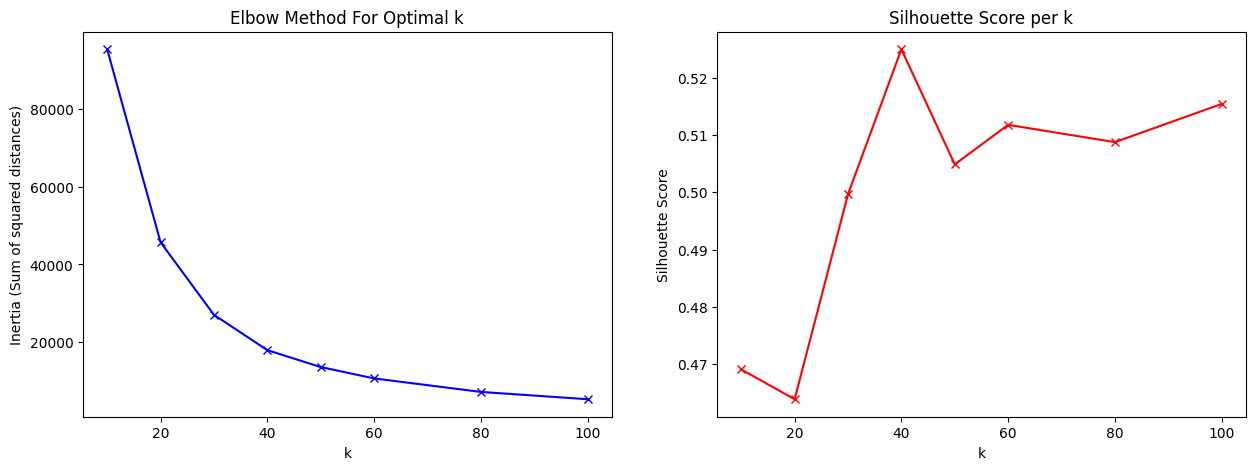

Best K found: 40


In [12]:
# 2. Optimize hyperparameter based on n_clusters
range_n_clusters = [10, 20, 30, 40, 50, 60, 80, 100] # Adjust range based on dataset size
best_k = 0
best_score = -1
inertias = []
sil_scores = []

print("Optimizing KMeans...")
for n_clusters in range_n_clusters:
    # Use the UMAP reduced data, it usually clusters better than raw SBERT
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X_umap_optimized)

    silhouette_avg = silhouette_score(X_umap_optimized, cluster_labels)
    inertias.append(clusterer.inertia_)
    sil_scores.append(silhouette_avg)

    print(f"For n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg:.4f}")

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = n_clusters

# Plotting the Elbow and Silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Plot
ax1.plot(range_n_clusters, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia (Sum of squared distances)')
ax1.set_title('Elbow Method For Optimal k')

# Silhouette Plot
ax2.plot(range_n_clusters, sil_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score per k')
plt.show()

print(f"Best K found: {best_k}")

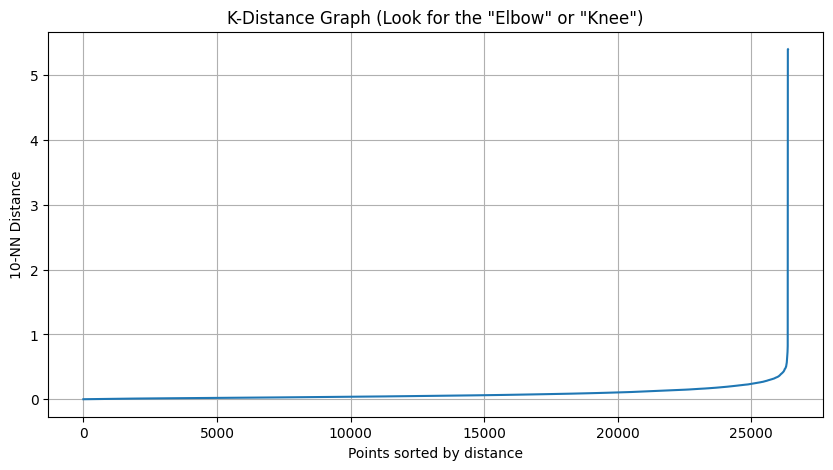

In [13]:
from sklearn.neighbors import NearestNeighbors

# 3. FIND OPTIMAL EPS FOR DBSCAN
# We look at the distance to the k-th nearest neighbor (k = 2 * n_components usually works)
k = 10 # Since we have 5 components in UMAP
nbrs = NearestNeighbors(n_neighbors=k).fit(X_umap_optimized)
distances, indices = nbrs.kneighbors(X_umap_optimized)

# Sort distance values by ascending value and plot
distance_desc = sorted(distances[:, k-1], reverse=False)

plt.figure(figsize=(10, 5))
plt.plot(distance_desc)
plt.title('K-Distance Graph (Look for the "Elbow" or "Knee")')
plt.ylabel(f'{k}-NN Distance')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

# INSTRUCTION: Look at the Y-axis value where the curve shoots up.
# That Y-value is your optimal 'eps'.

In [14]:
# --- FINAL CLUSTERING WITH OPTIMIZED PARAMS ---

# 1. Final KMeans
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
criteria_df['cluster_kmeans_opt'] = final_kmeans.fit_predict(X_umap_optimized)

# 2. Final DBSCAN (Replace 0.3 with the value from your K-distance plot)
# min_samples is usually good around 5 to 10 for this data size
final_dbscan = DBSCAN(eps=0.3, min_samples=10, metric='euclidean')
criteria_df['cluster_dbscan_opt'] = final_dbscan.fit_predict(X_umap_optimized)

# Calculate final score (Filtering out noise -1 for DBSCAN)
mask = criteria_df['cluster_dbscan_opt'] != -1
if mask.sum() > 0:
    score = silhouette_score(X_umap_optimized[mask], criteria_df.loc[mask, 'cluster_dbscan_opt'])
    print(f"Final Optimized DBSCAN Silhouette (excluding noise): {score:.4f}")

Final Optimized DBSCAN Silhouette (excluding noise): 0.0533


In [15]:
# Optimized DBSCAN application
# Look at the K-Distance graph above.
# Set 'best_eps' to the Y-value where the curve bends sharply (the "elbow").
best_eps = 0.15   # <--- CHANGE THIS based on your graph!

print(f"Running Final DBSCAN with eps={best_eps}...")
final_dbscan = DBSCAN(
    eps=best_eps,
    min_samples=10,
    metric='euclidean'
)

dbscan_umap_labels = final_dbscan.fit_predict(X_umap_optimized)
criteria_df["cluster_dbscan_opt"] = dbscan_umap_labels

print("Clustering complete.")

Running Final DBSCAN with eps=0.15...
Clustering complete.


In [17]:
mask = dbscan_labels != -1
X_non_noise = X_umap_optimized[mask]
labels_non_noise = dbscan_labels[mask]

if len(np.unique(labels_non_noise)) >= 2 and len(labels_non_noise) > 50:
    sample_idx = np.random.choice(
        X_non_noise.shape[0],
        size=min(5000, X_non_noise.shape[0]),
        replace=False
    )
    sil_dbscan_umap = silhouette_score(
        X_non_noise[sample_idx],
        labels_non_noise[sample_idx]
    )
    print("DBSCAN+UMAP silhouette (sample non-noise):", sil_dbscan_umap)
else:
    print("DBSCAN+UMAP silhouette cannot be computed (not enough clusters).")

DBSCAN+UMAP silhouette (sample non-noise): 0.070811


In [19]:
from sklearn.cluster import DBSCAN
best_eps = 0.15
best_min_samples = 10
print(f"Generating labels with eps={best_eps}...")
final_dbscan = DBSCAN(
    eps=best_eps,
    min_samples=best_min_samples,
    metric='euclidean'
)
labels = final_dbscan.fit_predict(X_umap_optimized)

criteria_df['cluster_dbscan_umap'] = labels

print("Column 'cluster_dbscan_umap' created successfully.")
print(f"Clusters found: {len(set(labels)) - (1 if -1 in labels else 0)}")

inspect_dbscan_umap(criteria_df, n_examples=5)

Generating labels with eps=0.15...
Column 'cluster_dbscan_umap' created successfully.
Clusters found: 275
DBSCAN+UMAP Cluster = 0
- [NCT00001137] HIV-1 infected
- [NCT00003895] Patients must be negative for human immunodeficiency virus (HIV) antibody by enzyme-linked immunosorbent assay (ELISA) (or negative by Western blot if ELISA is positive) if they are considered to be at high risk; others do not require serologic testing if there are no symptoms or risk factors for HIV disease
- [NCT00005764] Are HIV-positive.
- [NCT00005764] Have had HIV-1 RNA levels less than 400 copies/ml on the 2 most recent measurements.
- [NCT00005764] Have had an HIV vaccine within 3 months of the screening visit.

DBSCAN+UMAP Cluster = 1
- [NCT00001137] Willing to provide consent for the release and use of clinical data from the parent study
- [NCT00003199] The patient must have the capacity to give informed consent; the patient must have signed an approved consent form conforming with federal and institut

In [20]:
def inspect_dbscan_umap(df, label_col="cluster_dbscan_umap", n_examples=5):
    for label in sorted(df[label_col].unique()):
        if label == -1:   # skip noise
            continue
        subset = df[df[label_col] == label].head(n_examples)
        print("="*80)
        print(f"DBSCAN+UMAP Cluster = {label}")
        for _, row in subset.iterrows():
            print(f"- [{row['nctid']}] {row['criterion']}")
        print()

inspect_dbscan_umap(criteria_df, n_examples=5)


DBSCAN+UMAP Cluster = 0
- [NCT00001137] HIV-1 infected
- [NCT00003895] Patients must be negative for human immunodeficiency virus (HIV) antibody by enzyme-linked immunosorbent assay (ELISA) (or negative by Western blot if ELISA is positive) if they are considered to be at high risk; others do not require serologic testing if there are no symptoms or risk factors for HIV disease
- [NCT00005764] Are HIV-positive.
- [NCT00005764] Have had HIV-1 RNA levels less than 400 copies/ml on the 2 most recent measurements.
- [NCT00005764] Have had an HIV vaccine within 3 months of the screening visit.

DBSCAN+UMAP Cluster = 1
- [NCT00001137] Willing to provide consent for the release and use of clinical data from the parent study
- [NCT00003199] The patient must have the capacity to give informed consent; the patient must have signed an approved consent form conforming with federal and institutional guidelines
- [NCT00003895] Patients must give written informed consent prior to initiation of therap

In [21]:
def inspect_clusters(df: pd.DataFrame,
                     label_col: str,
                     n_examples: int = 5):
    for label in sorted(df[label_col].unique()):
        subset = df[df[label_col] == label].head(n_examples)
        print("=" * 80)
        print(f"Cluster {label_col} = {label}  (showing {len(subset)} examples)")
        for _, row in subset.iterrows():
            print(f"- [{row['nctid']}] {row['criterion']}")
        print()

# Example: quickly look at a few clusters in each method
inspect_clusters(criteria_df, "cluster_tfidf", n_examples=4)
inspect_clusters(criteria_df, "cluster_emb", n_examples=4)
print("DBSCAN AND DIM REDUCTION WITH UMAP")
inspect_clusters(criteria_df, "cluster_dbscan_umap", n_examples=5)


Cluster cluster_tfidf = 0  (showing 4 examples)
- [NCT00003199] ANC \> 1,000 cells/mm\^3 and platelets \> 30,000/cells/mm\^3 (transfusion independent) for at least 5 days before starting therapy
- [NCT00003895] Platelets (Plt) \>= 100,000/mm\^3
- [NCT00004067] The postoperative absolute neutrophil count (ANC) must be ≥ 1500/mm3 (or \<1500/mm3 if, in the opinion of the investigator, this represents an ethnic or racial variation of normal).
- [NCT00004067] Postoperative platelet count must be ≥ 100,000/mm3. Significant underlying hematologic disorders must be excluded when the platelet count is above the upper limit of normal for the lab.

Cluster cluster_tfidf = 1  (showing 4 examples)
- [NCT00024154] Male or female
- [NCT00201929] Female
- [NCT00217672] Female 18 and over
- [NCT00270972] Male or female

Cluster cluster_tfidf = 2  (showing 4 examples)
- [NCT00005617] Adults over the age of 18 with malignant melanoma.
- [NCT00028405] Age 18 or older.
- [NCT00044291] Women age 18 years or

In [22]:
# Map numbers to string labels
# Look at all clustering algorithms and see which ones are better


def numeric_to_string_labels(int_labels: np.ndarray) -> np.ndarray:
    uniq = np.unique(int_labels)
    mapping = {c: f"label{chr(ord('A') + i)}" for i, c in enumerate(uniq)}
    return np.array([mapping[c] for c in int_labels])

criteria_df["cluster_final"] = numeric_to_string_labels(criteria_df["cluster_emb"].values)

results_df = criteria_df[["nctid", "criterion", "cluster_final"]].copy()
results_df.columns = ["nctid", "criterion", "cluster"]


RESULTS_PATH = "results_sendroff_partner.txt"

results_df.to_csv(
    RESULTS_PATH,
    sep="\t",
    index=False
)

print("Saved results to", RESULTS_PATH)
results_df.head()


Saved results to results_sendroff_partner.txt


,nctid,criterion,cluster
0,NCT00001137,HIV-1 infected,labelK
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...,labelE
2,NCT00001137,Willing to provide consent for the release and...,labelE
3,NCT00001137,Life expectancy of at least 24 weeks,label[
4,NCT00001137,Parent or guardian willing to provide informed...,labelH


In [23]:
import numpy as np

# Helper function to map numbers to strings, handling Noise (-1)
def get_string_label(label):
    if label == -1:
        return "labelNoise"
    # Maps 0 -> labelA, 1 -> labelB, etc.
    # Using modulo 26 to wrap around if you have >26 clusters (labelA...labelZ, labelA...)
    letter = chr(ord('A') + (label % 26))
    suffix = str(label // 26) if label >= 26 else ""
    return f"label{letter}{suffix}"

# Apply to the Optimized DBSCAN column (or KMeans if that score was better!)
# Assuming DBSCAN was your best approach:
criteria_df["final_string_label"] = criteria_df["cluster_dbscan_opt"].apply(get_string_label)

# Create the final dataframe for export
final_results = criteria_df[["nctid", "criterion", "final_string_label"]].copy()
final_results.columns = ["nctid", "criterion", "cluster"]

# Save to .txt as requested
output_filename = "results_sendroff_partner.txt"
final_results.to_csv(output_filename, sep="\t", index=False)

print(f"Success! Saved {len(final_results)} rows to {output_filename}")
print(final_results.head())

Success! Saved 26369 rows to results_sendroff_partner.txt
         nctid                                          criterion     cluster
0  NCT00001137                                     HIV-1 infected      labelA
1  NCT00001137  Enrolled in an AIDS Clinical Trial Group (ACTG...  labelNoise
2  NCT00001137  Willing to provide consent for the release and...      labelB
3  NCT00001137               Life expectancy of at least 24 weeks      labelC
4  NCT00001137  Parent or guardian willing to provide informed...      labelD


In [ ]:

# Analyzation


